In [1]:
# prepend parent dir to import from local pcsp
import sys

sys.path.insert(0, '../')

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vflow
from vflow import Vset, init_args, dict_to_df
from vflow.pipeline import build_graph
from functools import partial
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.utils
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.inspection import permutation_importance

/Users/rush/anaconda3/envs/vflow/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/rush/anaconda3/envs/vflow/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/rush/anaconda3/envs/vflow/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/rush/Desktop/binyugroup/veridical-flow/vflow/pipeline.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  

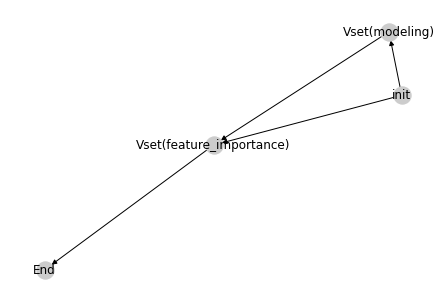

In [4]:
# load data
data_dir = "../../../_other/Enhancer/data/"
X_train = np.asarray(pd.read_csv(data_dir + "01_X_train.csv", error_bad_lines=False).iloc[:, 1:])
X_test = np.asarray(pd.read_csv(data_dir + "02_X_test.csv", error_bad_lines=False).iloc[:, 1:])
y_train = np.asarray(pd.read_csv(data_dir + "03_y_train.csv", error_bad_lines=False).iloc[:, 1])
y_test = np.asarray(pd.read_csv(data_dir + "04_y_test.csv", error_bad_lines=False).iloc[:, 1])

# initialize data
np.random.seed(14)
X_train, X_test, y_train, y_test = init_args((X_train, X_test, y_train, y_test),
                                             names=['X_train', 'X_test', 'y_train', 'y_test'])

# subsample
subsampling_fns = [partial(sklearn.utils.resample, n_samples=1000, random_state=i) for i in range(3)]

subsampling_set = Vset(name='subsampling', modules=subsampling_fns)
X_trains, y_trains = subsampling_set(X_train, y_train)

modeling_set = Vset(name='modeling',
                         modules=[RandomForestClassifier(n_estimators=50, max_depth=5), MLPClassifier()],
                         module_keys=["RF", "MLP"])

# model
modeling_set.fit(X_trains, y_trains)
preds = modeling_set.predict(X_test)

# hard metrics
hard_metrics_set = Vset(name='hard_metrics', modules=[accuracy_score, balanced_accuracy_score],
                             module_keys=["Acc", "Bal_Acc"])
hard_metrics = hard_metrics_set.evaluate(preds, y_test)

# permutation importance
feature_importance_set = Vset(name='feature_importance', modules=[permutation_importance])
importances = feature_importance_set.evaluate(modeling_set.out, X_test, y_test)

G = build_graph(importances, draw=True)
plt.show()

In [5]:
df = dict_to_df(hard_metrics)
df

,init-subsampling,init-subsampling,subsampling,init-modeling,modeling,init-hard_metrics,hard_metrics,out
0,X_test,X_train,subsampling_0,y_train,RF,y_test,Acc,0.926097
1,X_test,X_train,subsampling_1,y_train,RF,y_test,Acc,0.924557
2,X_test,X_train,subsampling_2,y_train,RF,y_test,Acc,0.924044
3,X_test,X_train,subsampling_0,y_train,MLP,y_test,Acc,0.907365
4,X_test,X_train,subsampling_1,y_train,MLP,y_test,Acc,0.907878
5,X_test,X_train,subsampling_2,y_train,MLP,y_test,Acc,0.901463
6,X_test,X_train,subsampling_0,y_train,RF,y_test,Bal_Acc,0.826515
7,X_test,X_train,subsampling_1,y_train,RF,y_test,Bal_Acc,0.794172
8,X_test,X_train,subsampling_2,y_train,RF,y_test,Bal_Acc,0.807060
9,X_test,X_train,subsampling_0,y_train,MLP,y_test,Bal_Acc,0.700783
